In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd   
from gensim import corpora, models, similarities, matutils
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
from gensim.matutils import cossim
from gensim.models.phrases import Phrases, Phraser
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import pickle
import random
import sys
from tqdm import tqdm
from sklearn import manifold
import tensorflow_datasets as tfds


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Word2vec tutorial
## Corpus Cleaning

In [4]:
# Split the training set into 60% and 40%, so we'll end up with 15,000 examples
# for training, 10,000 examples for validation and 25,000 examples for testing.
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])

(train_data, validation_data), test_data = tfds.load(
    name="imdb_reviews", 
    split=(train_validation_split, tfds.Split.TEST),
    as_supervised=True)

df_train = pd.DataFrame(list(tfds.as_numpy(train_data)),columns=['texto','clase'])
df_dev = pd.DataFrame(list(tfds.as_numpy(validation_data)),columns=['texto','clase'])
df_test = pd.DataFrame(list(tfds.as_numpy(test_data)),columns=['texto','clase'])

AssertionError: ignored

In [3]:
df_train.texto[0]

NameError: ignored

In [0]:
trainset = []
for rev in df_train.texto:
  rev = rev.decode('utf-8').lower()
  # clean review
  rev = re.sub('<.*?>',' ',rev)
  #split by sentence
  sentences = sent_tokenize(rev)
  for sent in sentences:
    # word tokenize and append the sentence as a list of words
    trainset.append([word for word in word_tokenize(sent) if word.isalpha()])

In [0]:
trainset[:3]

[['as',
  'a',
  'lifelong',
  'fan',
  'of',
  'dickens',
  'i',
  'have',
  'invariably',
  'been',
  'disappointed',
  'by',
  'adaptations',
  'of',
  'his',
  'novels'],
 ['although',
  'his',
  'works',
  'presented',
  'an',
  'extremely',
  'accurate',
  'of',
  'human',
  'life',
  'at',
  'every',
  'level',
  'in',
  'victorian',
  'britain',
  'throughout',
  'them',
  'all',
  'was',
  'a',
  'pervasive',
  'thread',
  'of',
  'humour',
  'that',
  'could',
  'be',
  'both',
  'playful',
  'or',
  'sarcastic',
  'as',
  'the',
  'narrative',
  'dictated'],
 ['in',
  'a',
  'way',
  'he',
  'was',
  'a',
  'literary',
  'caricaturist',
  'and',
  'cartoonist']]

In [0]:
print("el corpus tiene",len(trainset), "oraciones y",sum([len(x) for x in trainset]),"palabras"   )

el corpus tiene 184721 oraciones y 3402874 palabras


In [0]:
collocations = Phrases(sentences=trainset, min_count=10,threshold=0.5,scoring='npmi') # threshold: minimo score aceptado

In [0]:
to_collocations = Phraser(collocations)

In [0]:
df_collocations =pd.DataFrame([x for x in collocations.export_phrases(trainset)],columns=["bigram","score"])
df_collocations.shape

(74416, 2)

In [0]:
df_collocations.drop_duplicates().sort_values(by="score",ascending=False).head(50)

,bigram,score
3818,b'mardi gras',1.000000
1361,b'tel aviv',1.000000
1927,b'sci fi',0.990622
20896,b'hera pheri',0.986786
1519,b'rajpal yadav',0.984344
1307,b'tsui hark',0.983903
460,b'gunga din',0.982081
14280,b'joss ackland',0.979903
2251,b'kung fu',0.979050
3829,b'bon jovi',0.978878


In [0]:
trainset_ngrams = to_collocations[trainset]

In [0]:
# "window" es el tamaño de la ventana. windows = 10, usa 10 palabras a la izquierda y 10 palabras a la derecha
# "n_dim" es la dimension (i.e. el largo) de los vectores de word2vec
# "workers" es el numero de cores que usa en paralelo. Para aprobechar eso es necesario tener instalado Cython)
# "sample": word2vec filtra palabras que aparecen una fraccion mayor que "sample"
# "min_count": Word2vec filtra palabras con menos apariciones que  "min_count"
# "sg": para correr el Skipgram model (sg = 1), para correr el CBOW (sg = 0)
# para mas detalle ver: https://radimrehurek.com/gensim/models/word2vec.html

w2v_model = Word2Vec(trainset_ngrams, workers=4,size=20, min_count = 10, window = 10, sample = 1e-3,negative=5,sg=1)
#w2v_model.save("word2vec_20dim")  # save model
#w2v_model = Word2Vec.load("word2vec_20dim")  # load model

In [0]:
# the output of a word2vec representation is a numpy array 
w2v_model.wv["awesome"]

array([ 0.16857156,  0.65610373, -0.02666574,  0.5213076 ,  0.19909911,
        0.7968848 ,  0.07211578,  0.49932057,  0.0904531 ,  0.49882576,
       -0.4052642 ,  0.6480719 , -0.3706974 , -0.3188054 , -0.5154993 ,
       -0.5300336 ,  0.20405327, -0.05342718,  0.5780577 , -0.05301543],
      dtype=float32)

In [0]:
w2v_model.wv.n_similarity(["jim_carrey"], ["silly"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.5863942

In [0]:
print ("morgan_freeman-god similarity:",w2v_model.wv.n_similarity(["morgan_freeman"], ["god"]))
print ("jim_carrey-god similarity:",w2v_model.wv.n_similarity(["jim_carrey"], ["god"]) )

print ("\n")

print ("morgan_freeman-silly similarity:",w2v_model.wv.n_similarity(["morgan_freeman"], ["silly"]))
print ("jim_carrey-silly similarity:",w2v_model.wv.n_similarity(["jim_carrey"], ["silly"]) )
print ("\n")


morgan_freeman-god similarity: 0.5893011
jim_carrey-god similarity: 0.4200222


morgan_freeman-silly similarity: 0.42724645
jim_carrey-silly similarity: 0.5863942




/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
w2v_model.most_similar(positive=["jim_carrey"], negative=[], topn=25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('eddie_murphy', 0.9288574457168579),
 ('woody_allen', 0.9005715250968933),
 ('robin_williams', 0.8942154049873352),
 ('standup', 0.8936103582382202),
 ('depardieu', 0.8881456255912781),
 ('steve_carell', 0.8881300687789917),
 ('versatile', 0.8862303495407104),
 ('nicole_kidman', 0.8831904530525208),
 ('lorenzo_lamas', 0.8823767900466919),
 ('george_clooney', 0.8821420669555664),
 ('night_listener', 0.8810737729072571),
 ('parker_posey', 0.8807492256164551),
 ('goldie_hawn', 0.8793573975563049),
 ('imo', 0.8786233067512512),
 ('red_eye', 0.8778781890869141),
 ('matt_damon', 0.8761889934539795),
 ('simon_pegg', 0.8744803071022034),
 ('least', 0.874297022819519),
 ('james_belushi', 0.8727660179138184),
 ('peter_falk', 0.8720712065696716),
 ('paul_reiser', 0.870018720626831),
 ('adam_sandler', 0.8686364889144897),
 ('carrey', 0.8644373416900635),
 ('peter_sellers', 0.8643856048583984),
 ('oscar_worthy', 0.8640221357345581)]

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


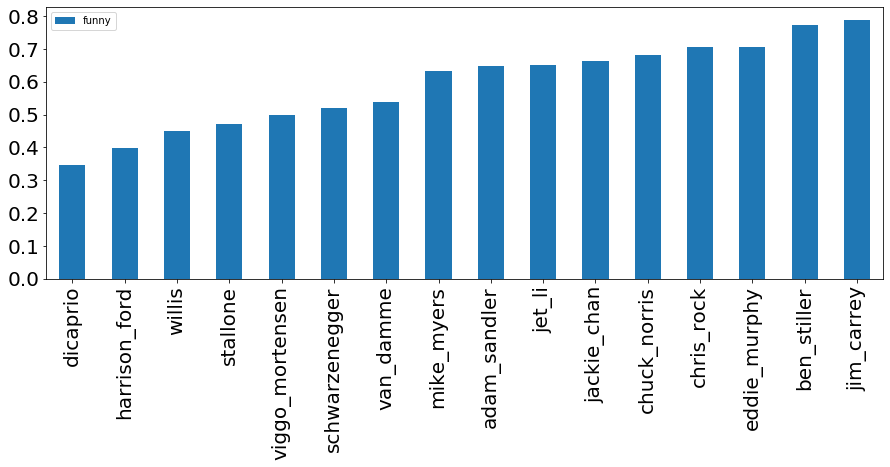

In [0]:
target_word="funny"
actores = ["adam_sandler","jim_carrey","ben_stiller","eddie_murphy","mike_myers","chris_rock","stallone","willis","jackie_chan",'jet_li',"van_damme","harrison_ford","schwarzenegger","chuck_norris",'dicaprio','viggo_mortensen']
fun_score = []
for actor in actores:
    fun_score.append(w2v_model.wv.n_similarity([target_word], [actor]))
    
pd.DataFrame(fun_score,index = actores,columns=[target_word]).sort_values(by=target_word).plot(kind="bar",figsize=(15,5), fontsize=20)

In [0]:
p_movies = ["horror","comedy","drama","science_fiction","western","documentary"]
p_actors_action = ["stallone","willis","jackie_chan",'jet_li',"van_damme","harrison_ford","schwarzenegger","chuck_norris"]
p_actors_comedy = ["adam_sandler","jim_carrey","ben_stiller","eddie_murphy","mike_myers","chris_rock"]
p_superheroes = ["batman","superman","spiderman","robocop","hulk","wolverine"]
p_colors = ["blue", "green", "yellow", "red", "orange"] # p_robos_en
palabras = p_movies + p_actors_action + p_actors_comedy + p_superheroes + p_colors
colores = ["black"]*len(p_movies)+["blue"]*len(p_actors_action)+["green"]*len(p_actors_comedy)+["red"]*len(p_superheroes) +["purple"]*len(p_colors)

In [0]:
# Armo una matriz de distancias
distancias=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias[i,j] = abs(1-w2v_model.wv.similarity(ti,tj))
print (distancias.shape)
distancias

(31, 31)


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


array([[0.00000000e+00, 1.52326286e-01, 2.85298944e-01, 1.26491487e-01,
        2.34343171e-01, 4.00589287e-01, 4.78317201e-01, 7.37112880e-01,
        1.53208613e-01, 2.26029754e-01, 3.76090407e-01, 6.22105271e-01,
        3.18962753e-01, 2.95305729e-01, 3.29968333e-01, 3.13598216e-01,
        4.19845760e-01, 4.06145751e-01, 4.61970150e-01, 2.97317922e-01,
        4.02485013e-01, 4.77005780e-01, 2.29412615e-01, 3.21708083e-01,
        5.08690238e-01, 5.82769454e-01, 5.92790931e-01, 6.68358862e-01,
        5.13418674e-01, 5.92495650e-01, 6.29589111e-01],
       [1.52326286e-01, 5.96046448e-08, 1.61139250e-01, 2.26438642e-01,
        2.81086385e-01, 5.18969983e-01, 3.97235274e-01, 5.93524307e-01,
        1.38619483e-01, 1.94260955e-01, 3.44962418e-01, 5.66687316e-01,
        3.49336326e-01, 2.67278850e-01, 3.17764103e-01, 1.86915696e-01,
        2.84278512e-01, 3.04820657e-01, 4.14013505e-01, 2.69152164e-01,
        4.24551427e-01, 5.18823117e-01, 3.16878498e-01, 4.06100094e-01,
       

In [0]:
# Reduccion de la dimensionalidad y visualizacion 
from sklearn.manifold import MDS
from sklearn.manifold import TSNE 
def visualize_embeddings(distancias,palabras,colores,perplexity):
    plt.figure(figsize=(20,10))
    # Reduccion de la dimensionalidad y visualizacion 
    mds = MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=123,
                       dissimilarity="precomputed", n_jobs=4)
    Y = mds.fit(distancias).embedding_
    plt.subplot(1,2,1)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("MDS")
    # Reduccion de la dimensionalidad y visualizacion 
    tsne = TSNE(n_components=2,metric="precomputed",learning_rate=1000, random_state=123,perplexity=perplexity)
    np.set_printoptions(suppress=True)
    plt.subplot(1,2,2)
    Y = tsne.fit_transform(distancias)
    plt.scatter(Y[:, 0], Y[:, 1],color="black",s=3)
    for label, x, y, color in zip(palabras, Y[:, 0], Y[:, 1],colores):
        plt.annotate(label, xy=(x, y), xytext=(0, 0),color=color, textcoords='offset points',size=13)
    plt.title("TSNE")

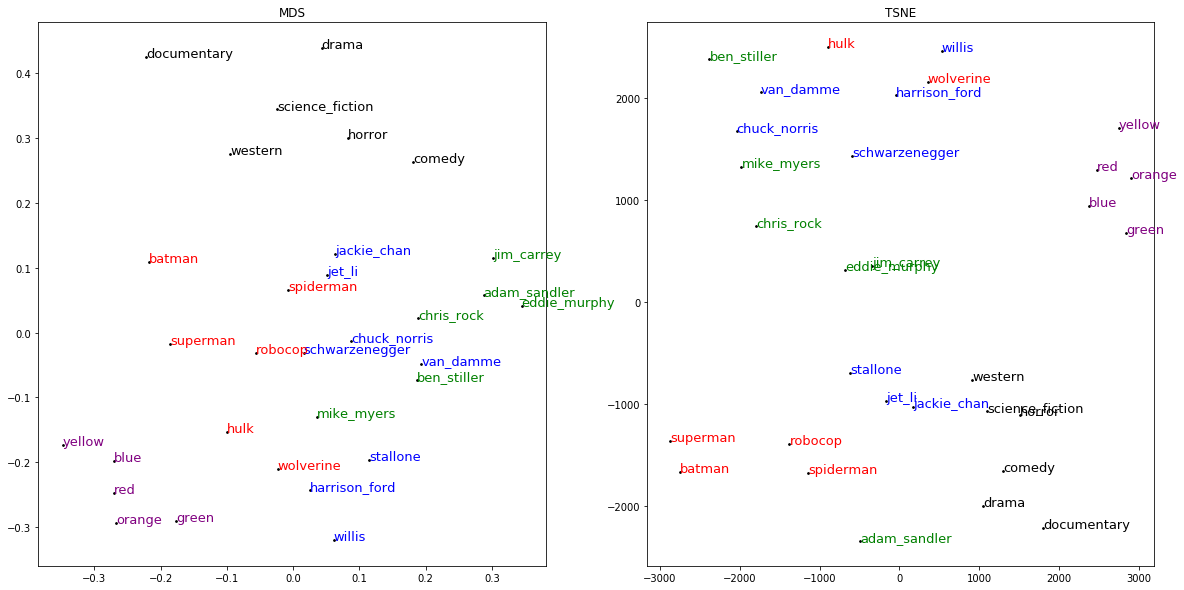

In [0]:
visualize_embeddings(distancias,palabras,colores,perplexity=4)

# Latent Semantic Analisis (LSA)

In [0]:
# Creates a dictionary wich maps tokens with Ids
dictionary = corpora.Dictionary(trainset)
# filter words with low frequency
dictionary.filter_extremes(no_below=10, no_above=1, keep_n=100000)

In [0]:
list(dictionary.iteritems())[:15]

[(0, 'a'),
 (1, 'adaptations'),
 (2, 'as'),
 (3, 'been'),
 (4, 'by'),
 (5, 'dickens'),
 (6, 'disappointed'),
 (7, 'fan'),
 (8, 'have'),
 (9, 'his'),
 (10, 'i'),
 (11, 'invariably'),
 (12, 'lifelong'),
 (13, 'novels'),
 (14, 'of')]

In [0]:
# me quedo con todos los tokens menos los "bad_ids" o sino con todos los "good_ids
# stopwords_id =np.array(dictionary.doc2bow(stopwords.words('english')))[:,0]
# dictionary.filter_tokens(bad_ids=stopwords_id, good_ids=None) 
# dictionary.save("diarios_dictionary.dict")

In [0]:
corpus = [dictionary.doc2bow(line) for line in trainset]
tfidf = models.TfidfModel(corpus)  # tf-idf  transformation
corpus_tfidf = tfidf[corpus]

In [0]:
corpus_tfidf

In [0]:
n_topics = 100
lsa_tfidf = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics = n_topics)  # initialize an LSI transformation
#lsa_tfidf.save("LSA_movies.lsi") # Save LSA
#lsa_tfidf = models.LsiModel.load("LSA_movies.lsi")

In [0]:
# vectorial representation of a token
vect_zombie = lsa_tfidf[dictionary.doc2bow(["zombie"])] 
vect_zombie[:10] # shows only the first 10 elements


[(0, 0.0038318839635359753),
 (1, 0.0013531129556720015),
 (2, -0.000776133048674863),
 (3, 0.0016280182760104681),
 (4, -0.001559830227048314),
 (5, 0.0012034692658344775),
 (6, -0.0012911852824828197),
 (7, 0.0004867577246034324),
 (8, 0.001334338373471997),
 (9, 0.0005393935157640736)]

In [0]:
# show the components of topic 60
lsa_tfidf.show_topic(8, topn=15)

[('what', -0.5749283714490503),
 ('film', -0.289359127828178),
 ('good', 0.28565208484730004),
 ('as', 0.24733067332931474),
 ('movie', 0.24488720055413493),
 ('is', -0.2308699601024843),
 ('no', -0.2058913535952318),
 ('not', 0.15118596488579553),
 ('they', 0.1393351303899248),
 ('about', -0.13491505358258984),
 ('very', 0.1324797683031347),
 ('bad', 0.12450946547041838),
 ('have', 0.12391990307805038),
 ('that', -0.11391916738565275),
 ('it', -0.10989595274250627)]

In [0]:
# Armo una matriz de distancias
distancias_lsa=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias_lsa[i,j] = abs(1-cossim(lsa_tfidf[dictionary.doc2bow([ti])] ,lsa_tfidf[dictionary.doc2bow([tj])]))
print( distancias_lsa.shape )


(31, 31)


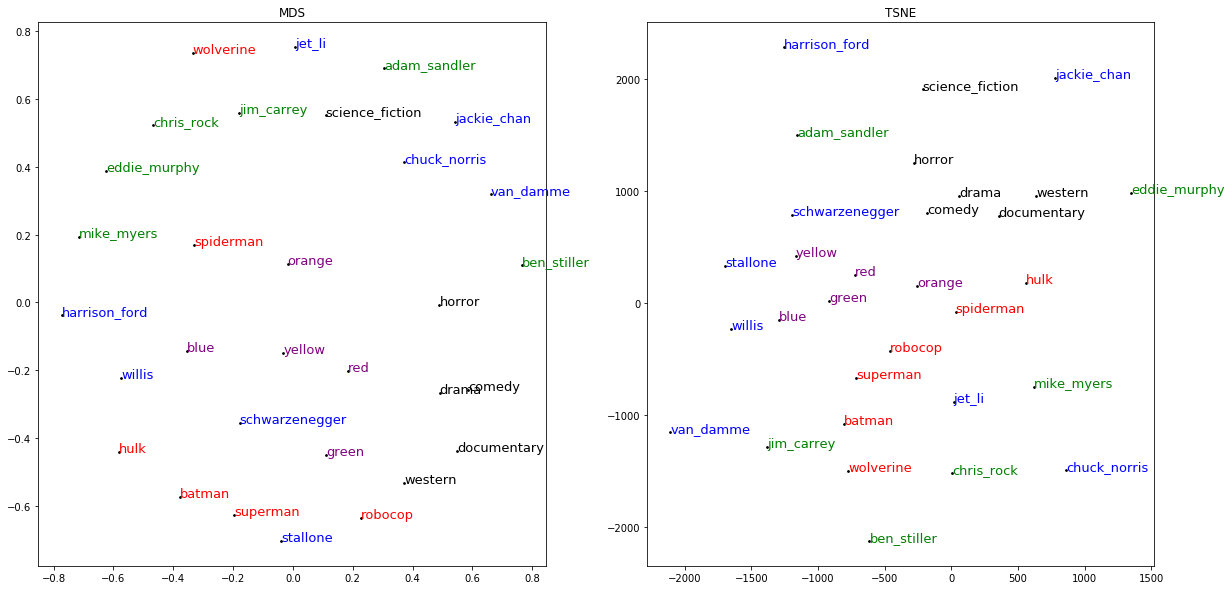

In [0]:
visualize_embeddings(distancias_lsa,palabras,colores,perplexity=5)

# Pretrained Word-embedding

In [0]:
!wget https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz

--2019-11-08 23:35:10--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.179.189
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.179.189|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.8MB/s    in 45s     

2019-11-08 23:35:56 (34.8 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [0]:
w2v_model2 = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
p_robos_en = ["robberies", "weapons", "murder", "thieves", "robbery", "assault"]
p_ciencias_en = ["biology", "chemistry", "mathematics", "philosophy", "psychology", "science", "engineering"]
p_tiempo_en = ["rainy", "sunny", "heat", "cloudy", "snow", "storm"]
p_paises_en = ["Switzerland", "Sweden", "France", "Netherlands", "Peru", "Bolivia", "Paraguay", "Uruguay","Argentine" ,"Brazil", "Colombia"]
p_comida_en = ["bread", "noodles", "cookies", "cheese", "pizza", "beer", "wine"]
p_tecno_en = ["technology", "computer", "internet", "web", "hackers", "monitor", "mouse"]
p_hogar_en = ["kitchen", "bathroom", "dining_room", "armchairs", "wardrobe", "chairs", "tables", "tableware"]
grupos = [p_robos_en,p_ciencias_en,p_tiempo_en,p_paises_en,p_comida_en,p_tecno_en,p_hogar_en]
palabras = p_robos_en + p_ciencias_en + p_tiempo_en + p_paises_en + p_comida_en + p_tecno_en +p_hogar_en
colores = ["black"]*len(p_robos_en)+["blue"]*len(p_ciencias_en)+["green"]*len(p_tiempo_en)+["red"]*len(p_paises_en) +["purple"]*len(p_comida_en)+["orange"]*len(p_tecno_en)+["cyan"]*len(p_hogar_en) 

In [0]:
# Armo una matriz de distancias
distancias_pre=np.zeros((len(palabras),len(palabras))) #matriz cuadrada
for i,ti in enumerate(palabras):
    for j,tj in enumerate(palabras):
        distancias_pre[i,j] = abs(1-w2v_model2.wv.similarity(ti,tj))
print (distancias_pre.shape)

(52, 52)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


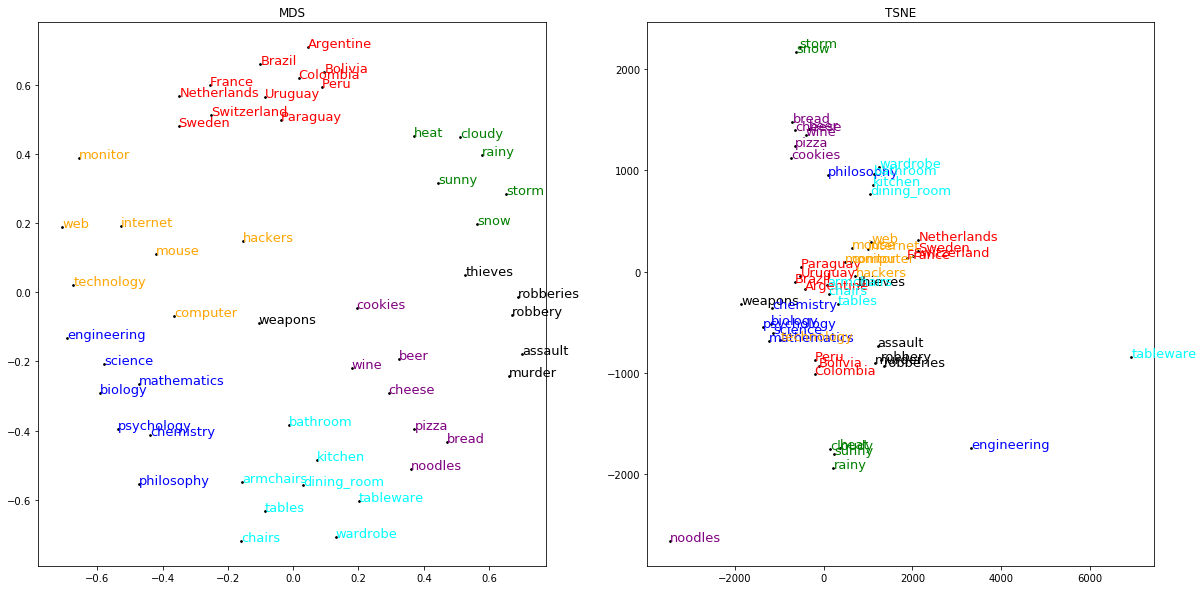

In [0]:
visualize_embeddings(distancias_pre,palabras,colores,perplexity=2)

In [0]:
print ("woman-kitchen similarity:",w2v_model2.wv.n_similarity(["woman"], ["kitchen"]))
print ("man-kitchen similarity:",w2v_model2.wv.n_similarity(["man"], ["kitchen"]) )
print ("\n")
print ("woman-wife similarity:",w2v_model2.wv.n_similarity(["woman"], ["wife"]) )
print ("man-husband similarity:",w2v_model2.wv.n_similarity(["man"], ["husband"]) )
print("\n")
print ("woman-children similarity:",w2v_model2.wv.n_similarity(["woman"], ["children"]) )
print ("man-children similarity:",w2v_model2.wv.n_similarity(["man"], ["children"]) )
print("\n")

woman-kitchen similarity: 0.13754271
man-kitchen similarity: 0.076843694


woman-wife similarity: 0.444824
man-husband similarity: 0.34499747


woman-children similarity: 0.34372672
man-children similarity: 0.19058806




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed 

# Ganando un poco de intuición

In [0]:
print ("bank-money similarity:",w2v_model2.wv.n_similarity(["bank"], ["money"]) )
print ("bank-park similarity:",w2v_model2.wv.n_similarity(["bank"], ["park"]) )

bank-money similarity: 0.26132065
bank-park similarity: 0.12146981


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [0]:
print(w2v_model2.n_similarity(["Argentine"], ["park"]),'\n')

-0.009703358 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model2.n_similarity(["Argentine"], ["money"]),'\n')

0.010083034 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model2.n_similarity(["run"], ["monkey"]),'\n')

0.09768893 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model2.n_similarity(["wizard"], ["happy"]),'\n')

0.055537175 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model2.n_similarity(["money"], ["wealthy"]),'\n')

0.32006815 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model2.n_similarity(["money"], ["bankrupt"]),'\n')

0.32392168 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model2.n_similarity(["good"], ["happy"]),'\n')

0.16610375 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model2.n_similarity(["good"], ["bad"]),'\n')

0.7190051 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
print(w2v_model2.n_similarity(["black"], ["white"]),'\n')

0.80922145 



/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# volviendo a los reviews

In [0]:
w2v_model.wv.n_similarity(["black"],["white"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.9639767

In [0]:
w2v_model.wv.n_similarity(["orange"],[""])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.7924628